<a href="https://colab.research.google.com/github/Ares9505/Ares9505/blob/main/Practica1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Los archivos de audio seran analizados desde drive
#por tanto se debe montar la cuenta de drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#librerias necesarias

#Usadas para descompresion de audios
import os
import zipfile

#Usadas para en extraccion de caracteristicas
import librosa
import numpy as np
import pandas as pd

#para visualizacion de datos
import matplotlib.pyplot as plt
import seaborn as sns

#Usadas para la extraccion de features de audio
import librosa.display

#Standar scaler para normalizar los datos
from sklearn.preprocessing import StandardScaler

#Para la estadistica de los modelos
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_score

#para crear los modelos de clasificacion
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#para conversion de formatos de audio
#fue necesario instalar pydub
!pip install pydub
from pydub import AudioSegment


#variables globales
dir_audios_comprimidos = '/content/drive/My Drive/Ciencia de datos/Datos de voz comprimidos'
dir_audios = '/content/drive/My Drive/Ciencia de datos/Datos de voz'


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

#Descompresion de archivos
def extract_all_zip_files(dir_audios_comprimidos, dir_audios ):
    for item in os.listdir(dir_audios_comprimidos):
        if item.endswith('.zip'):
            file_path = os.path.join(dir_audios_comprimidos, item)
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                zip_ref.extractall(dir_audios)

extract_all_zip_files(dir_audios_comprimidos, dir_audios)


In [ ]:

#Extracción de características
def extraer_caracteristicas(audio):

  #ceptrales mfcc
  mfcc = librosa.feature.mfcc(audio, sr= sample_rate)
  mfcc_features= np.mean(mfcc, axis=1)
  
  #center of gravity,  or roll-off points 
  cof = librosa.feature.spectral_centroid(y= audio, sr=sample_rate)[0]
  cof_mean= np.mean(cof)

  #valor rms
  rms = np.mean(librosa.feature.rms(y=audio).T, axis=0)

  #Tasa de cruces por cero
  zcr = np.mean(librosa.feature.zero_crossing_rate(y=audio).T, axis=0)

  #ritmo
  tempo, beats = librosa.beat.beat_track(y=audio, sr=sample_rate)

  # velocidad de habla
  duracion_audio = len(audio)/sample_rate
  numero_de_palabras = 2 #Numero de palabras de la frase "estoy bien"
  velocidad_habla =  numero_de_palabras/duracion_audio

  #energy
  energy = np.sum(np.abs(audio) ** 2)

  #Mel Spectrogram
  mel = np.mean(librosa.feature.melspectrogram(audio, sr=sample_rate).T, axis=0)
  
  #Chroma
  stft = np.abs(librosa.stft(audio))
  chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
  resultado = np.hstack((mfcc_features, rms, zcr, mel, chroma, velocidad_habla, energy, tempo, cof_mean))

  return resultado

#prueba de longitud de resultados
path = '/content/drive/My Drive/Ciencia de datos/Datos de voz/Ariel/Enojo_05.wav'
audio, sample_rate = librosa.load(path)
len(extraer_caracteristicas(audio))


166

Text(0.5, 1.0, 'Señal de audio recortada')

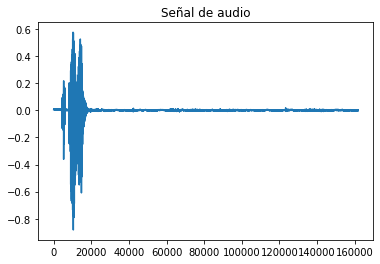

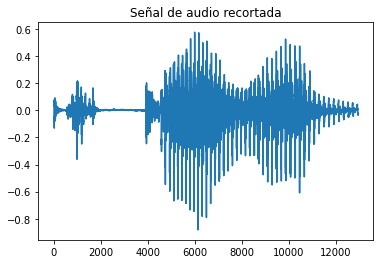

In [ ]:

#para remover silencios al inicio y al final del audio
def eliminar_silencio(audio,sr):
  energy = np.abs(audio) ** 2

  # Identificar el inicio y final de los segmentos no silenciosos
  esize = len(energy)
  start = 0
  end = esize
  for i in range(esize):
    if energy[i] > np.mean(energy):
      start = i
      break
  
  rev = np.flip(energy)
 
  for j in range(esize):
      if rev[j] > np.mean(energy):
        end = esize - j
        break
  audio2 = audio[start:end]

  return audio2

#Prueba de eliminacion de silencio
path = '/content/drive/My Drive/Ciencia de datos/Datos de voz/Ariel/Enojo_02.wav'
audio, sample_rate = librosa.load(path)
audio_refinado = eliminar_silencio(audio,sample_rate)
fig, ax = plt.subplots()
ax.plot(audio)
plt.title("Señal de audio")

fig2, ax2 = plt.subplots()
ax2.plot(audio_refinado)
plt.title("Señal de audio recortada")



In [ ]:
#Esta celda se corre solo para llenar el dataset con los features
#no es necesario correrlo porque demora en cargar los datos
#en la primera corrida se guardo en un csv
def crear_datasets_caracteristicas_audio(path, erase_silence= False):
  X = []
  Y = []
  i= 0
  for root, dirs, files in os.walk(path):
      for file in files:
        if 'Enojo' in file:
          animo = "enojo"
        if 'Feliz' in file:
          animo = "feliz"
        if 'Triste' in file:
          animo = "triste"
        Y.append(animo)
        full_path = os.path.join(root, file)
        audio, sample_rate = librosa.load(full_path)
        if erase_silence:
          audio = eliminar_silencio(audio, sample_rate)
        row = extraer_caracteristicas(audio)
        X.append(row)
  df = pd.DataFrame(X)
  df['Animo'] = Y
  return df

dataset_bruto = crear_datasets_caracteristicas_audio(dir_audios)
#dataset_sin_silencio = crear_datasets_caracteristicas_audio(dir_audios, True)

In [ ]:
dataset_bruto

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,Animo
0,-500.330536,33.001232,2.331309,60.710155,0.683774,22.785206,9.769106,5.271969,10.536577,8.534635,...,0.711508,0.725781,0.792770,0.798628,0.812787,0.350133,36.656708,151.999081,3032.569461,triste
1,-447.073730,21.206549,0.804328,51.679253,2.310961,16.775400,8.367042,4.960811,8.557352,9.482676,...,0.690134,0.706787,0.732618,0.838668,0.885738,0.382813,336.320892,92.285156,3411.188331,feliz
2,-381.870605,46.346684,-9.333334,45.731392,-1.279546,14.217352,0.466353,1.555971,6.410751,7.772215,...,0.634036,0.655331,0.726373,0.806263,0.841448,1.285564,62.510944,112.347147,3096.995623,triste
3,-473.631287,16.170135,0.809467,55.398594,2.881680,19.169958,12.577162,3.467429,11.605652,8.515680,...,0.716640,0.725409,0.743763,0.857657,0.876236,0.304356,268.141388,198.768029,3346.222153,feliz
4,-404.430695,19.811058,-6.297826,43.863605,1.050614,19.805326,1.902076,7.284824,1.757556,11.231914,...,0.738933,0.758029,0.810593,0.886292,0.847792,0.652521,119.686096,89.102909,3724.152056,enojo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,-474.224884,32.300976,-0.117499,63.702236,0.430693,22.235199,6.965478,8.241302,6.546723,8.522129,...,0.716266,0.729147,0.737886,0.759588,0.841145,0.828200,16.453623,143.554688,3036.147380,triste
296,-509.405975,14.747906,5.644672,61.054810,2.425495,23.484835,13.766784,10.192158,9.141727,11.292126,...,0.702845,0.681150,0.715723,0.767189,0.872169,0.151642,39.657108,135.999178,3445.951053,enojo
297,-428.259521,23.361744,0.082939,57.460873,1.845805,18.540766,5.233206,6.881808,5.236468,7.780406,...,0.658281,0.697498,0.746587,0.819365,0.885014,1.025391,36.194992,143.554688,3283.930748,enojo
298,-478.475494,22.582685,-3.096385,65.352486,-0.007560,23.121386,7.824754,11.815963,8.161368,9.833322,...,0.704678,0.703486,0.718551,0.752064,0.796887,0.594019,22.906616,143.554688,3232.658229,triste


In [ ]:
#guardo el dataset para no tener que correr el codigo cada vez que necesite sino cargarlo
dataset_bruto.to_csv('/content/drive/My Drive/Ciencia de datos/dataset_entero.csv', index=False)
#dataset_sin_silencio.to_csv('/content/drive/My Drive/Ciencia de datos/dataset_sin_silencio.csv', index=False)

In [ ]:
dataset_bruto = pd.read_csv('/content/drive/My Drive/Ciencia de datos/dataset_entero.csv', index=False)
#dataset_bruto = pd.read_csv('/content/drive/My Drive/Ciencia de datos/dataset_sin_silencio.csv', index=False)

In [ ]:
def extrayendo_train_test(dataset): 
  #Separando datos de entrenamiento y de prueba
  #dataset  = pd.read_csv('/content/drive/My Drive/Ciencia de datos/dataset_con_silencios.csv')
  X = dataset.iloc[: ,:-1].values
  Y = dataset['Animo'].values
  x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
  return x_train, x_test, y_train, y_test

#Normalizando los datos con estandar escaler
def crear_standar_scaler( x_train):
  scaler = StandardScaler()
  x_train = scaler.fit_transform(x_train)
  return x_train,scaler

x_train, x_test, y_train, y_test = extrayendo_train_test(dataset_bruto)
#x_train, x_test, y_train, y_test = extrayendo_train_test(dataset_sin_silencio)

#Se crea un standar scaler que tambien se utilizara en la etapa de validacion externa
#con los datos recogidos
x_train,scaler = crear_standar_scaler(x_train)
x_test = scaler.transform(x_test)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((240, 166), (240,), (60, 166), (60,))

#Clasificacion usando algoritmos de machine learning #

In [ ]:
#Definiendo presentacion de resultados de clasificacion
#Accuaracy, matriz de confusion y reporte de clasificacion
def resultados_clasificador(x_test, y_test, clf, name_clf, y_pred_clf):
  score_clf = clf.score(x_test,y_test)
  print(name_clf)
  print("------------------")
  print(f'El accuaracy para {name_clf} es de {round(score_clf, ndigits = 3)*100}%')
  print("\n")

  cm = confusion_matrix(y_test, y_pred_clf)
  plt.figure(figsize = (10, 10))
  sns.heatmap(cm, linecolor='white', cmap='Reds', linewidth=2, annot=True, fmt='')
  plt.title(name_clf, size=15)
  plt.xlabel('Predicted Labels', size=10)
  plt.ylabel('Actual Labels', size=10)
  plt.show()

  print("\n")
  clf_report = classification_report(y_test, y_pred_clf)
  print(clf_report)
  return score_clf

SVM
------------------
El accuaracy para SVM es de 51.7%




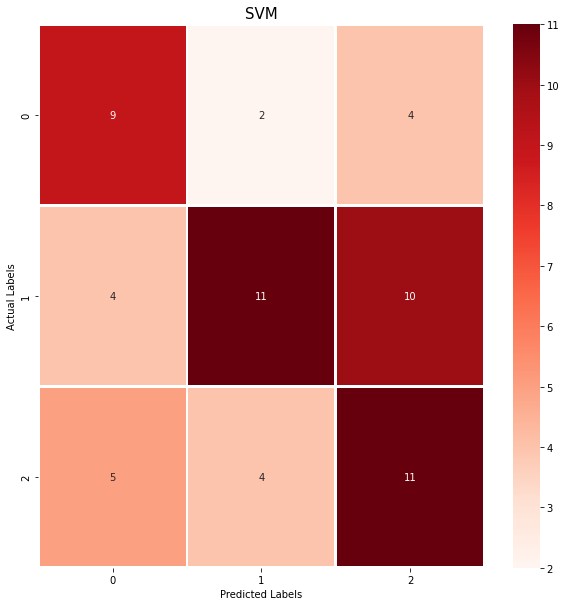



              precision    recall  f1-score   support

       enojo       0.50      0.60      0.55        15
       feliz       0.65      0.44      0.52        25
      triste       0.44      0.55      0.49        20

    accuracy                           0.52        60
   macro avg       0.53      0.53      0.52        60
weighted avg       0.54      0.52      0.52        60



In [ ]:

#creando clasificador
svm_m = svm.SVC(kernel='linear', C=1)

#Entrenar al clasificador
svm_m.fit(x_train, y_train)

# Realizar predicciones en los datos de prueba
y_pred_svm = svm_m.predict(x_test)

#Imprimir Accuracy, matriz de confusion
score_svm = resultados_clasificador(x_test, y_test, svm_m, "SVM", y_pred_svm)

KNN
------------------
El accuaracy para KNN es de 58.3%




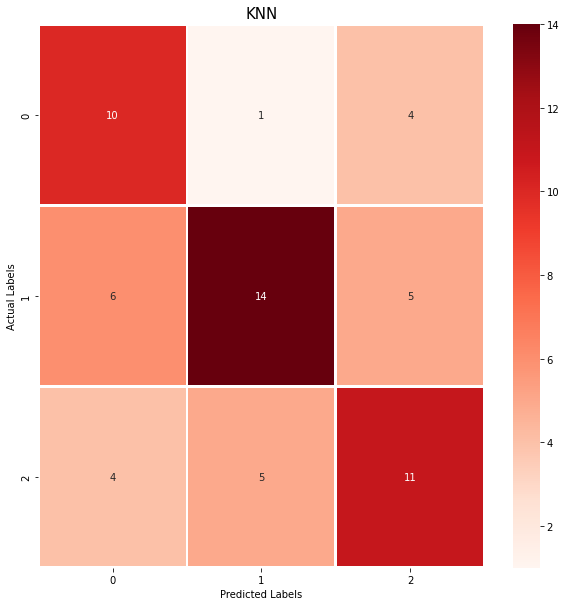



              precision    recall  f1-score   support

       enojo       0.50      0.67      0.57        15
       feliz       0.70      0.56      0.62        25
      triste       0.55      0.55      0.55        20

    accuracy                           0.58        60
   macro avg       0.58      0.59      0.58        60
weighted avg       0.60      0.58      0.59        60



In [ ]:
#creando clasificador
knn = KNeighborsClassifier()

#entrenando clasificador
knn.fit(x_train,y_train)

#haciendo prediccion
y_pred_knn = knn.predict(x_test)

score_knn = resultados_clasificador( x_test, y_test, knn, "KNN", y_pred_knn)

Decision Tree
------------------
El accuaracy para Decision Tree es de 50.0%




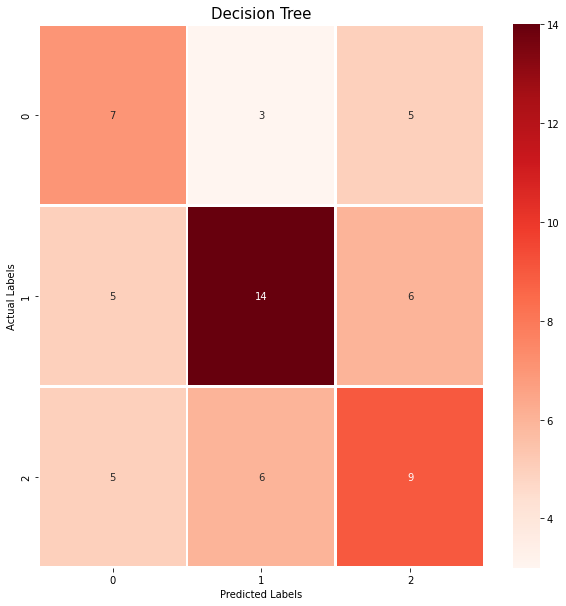



              precision    recall  f1-score   support

       enojo       0.41      0.47      0.44        15
       feliz       0.61      0.56      0.58        25
      triste       0.45      0.45      0.45        20

    accuracy                           0.50        60
   macro avg       0.49      0.49      0.49        60
weighted avg       0.51      0.50      0.50        60



In [ ]:
 #creando clasificador
dt = DecisionTreeClassifier()

#entrenando clasificador
dt.fit(x_train,y_train)

#haciendo prediccion
y_pred_dt = dt.predict(x_test)

score_dt = resultados_clasificador( x_test, y_test, dt, "Decision Tree", y_pred_dt)

Random Forest
------------------
El accuaracy para Random Forest es de 65.0%




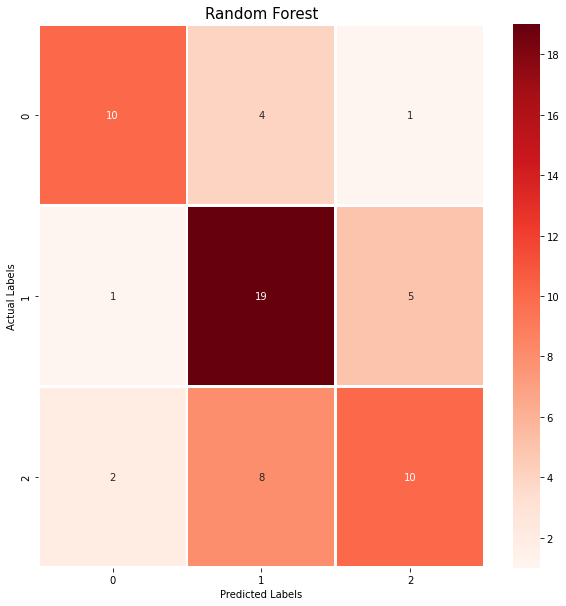



              precision    recall  f1-score   support

       enojo       0.77      0.67      0.71        15
       feliz       0.61      0.76      0.68        25
      triste       0.62      0.50      0.56        20

    accuracy                           0.65        60
   macro avg       0.67      0.64      0.65        60
weighted avg       0.66      0.65      0.65        60



In [ ]:
 #creando clasificador
rf = RandomForestClassifier(n_estimators=10, criterion='entropy', random_state=42)

#entrenando clasificador
rf.fit(x_train,y_train)

#haciendo prediccion
y_pred_rf = rf.predict(x_test)

score_rf = resultados_clasificador( x_test, y_test, rf, "Random Forest", y_pred_rf)

## Validacion cruzada ##

In [ ]:


#Se van a utilizar todos los datos para realizar validacion cruzada
X = dataset_bruto.iloc[: ,:-1].values
Y = dataset_bruto['Animo'].values

#X = dataset_sin_silencio.iloc[: ,:-1].values
#Y = dataset_sin_silencio['Animo'].values

scaler = StandardScaler()
X = scaler.fit_transform(X)
X.shape, Y.shape



((300, 166), (300,))

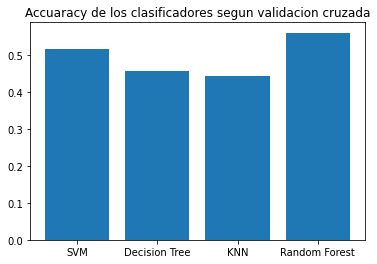

[0.5166666666666666, 0.4566666666666668, 0.4433333333333333, 0.56]


In [ ]:
def validacion_cruzada(clf, clf_name, X_k , y_k):
  
  #se usa StratifiedKFlod para que los datos esten balanceados en cada division
  sk_folds = StratifiedKFold(n_splits = 30)

  scores = cross_val_score(clf, X_k, y_k, cv = sk_folds)
  return scores.mean()

score_list = []
algo_list =  ["SVM","Decision Tree","KNN", "Random Forest"]

svm_m_2 = svm.SVC(kernel='linear', C=1)
score_list.append(validacion_cruzada(svm_m_2, "SVM", X , Y))

dt_2    = DecisionTreeClassifier()
score_list.append(validacion_cruzada(dt_2, "Decision Tree", X , Y))

knn_2   = KNeighborsClassifier()
score_list.append(validacion_cruzada(knn_2, "KNN", X , Y))

rf_2 = RandomForestClassifier(n_estimators=10, criterion='entropy', random_state=42)
score_list.append(validacion_cruzada(rf_2, "Random Forest", X , Y))

x = np.arange(3)
plt.bar( algo_list, score_list)
plt.title("Accuaracy de los clasificadores segun validacion cruzada")
plt.show()
print(score_list)

## Validadion externa ##

In [ ]:
#variables de prueba de la funcion convertir
origen = '/content/drive/My Drive/Ciencia de datos/Datos de voz para test'
destino = '/content/drive/My Drive/Ciencia de datos/Datos de voz para test wav'

#convirtiendo audios recopilados ogg a wav
def convertir_audios_ogg_wav(origen, destino):
  i = 0 #para que no queden los mismos nombre
  for root, dirs, files in os.walk(origen):  
      for file in files:
        full_path = os.path.join(root, file)
        if 'enoj' in full_path:
          nombre = "Enojo"
        if 'feliz' in full_path:
          nombre = "Feliz"
        if 'triste' in full_path:
          nombre = "Triste"
        hablante =  os.path.basename(os.path.dirname(root))
        audio = AudioSegment.from_ogg(full_path)
        audio.export(destino +"/"+ nombre + "_" + hablante + str(i) + ".wav", format="wav")
        i+=1    
  return

convertir_audios_ogg_wav(origen, destino)


In [ ]:
#extraer caracteristicas y guardar dataset
dataset_test = crear_datasets_caracteristicas_audio(destino) 
dataset_test.to_csv('/content/drive/My Drive/Ciencia de datos/dataset_para_validacion.csv', index=False)
#dataset_test_sin_silencio = crear_datasets_caracteristicas_audio(destino, True) 
#dataset_test_sin_silencio.to_csv('/content/drive/My Drive/Ciencia de datos/dataset_para_validacion_sin_silencio.csv', index=False)

In [ ]:
dataset_test

SVM
------------------
El accuaracy para SVM es de 46.7%




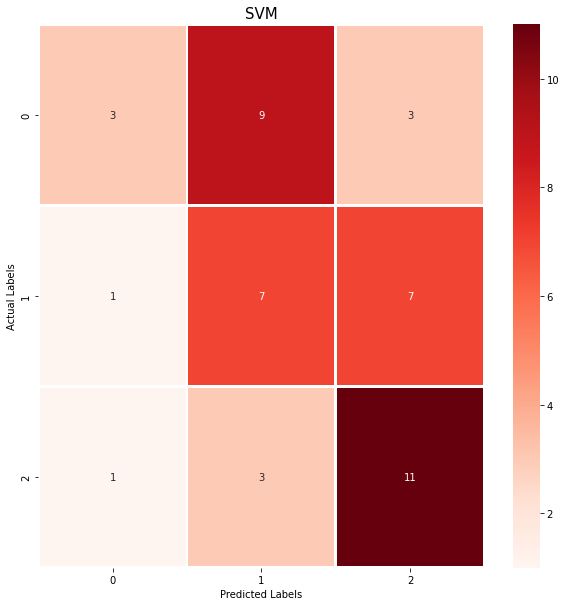



              precision    recall  f1-score   support

       enojo       0.60      0.20      0.30        15
       feliz       0.37      0.47      0.41        15
      triste       0.52      0.73      0.61        15

    accuracy                           0.47        45
   macro avg       0.50      0.47      0.44        45
weighted avg       0.50      0.47      0.44        45



0.4666666666666667

In [ ]:
#separar en tarin test y normalizar caracteristicas
x_test_v = dataset_test.iloc[: ,:-1].values
y_test_v = dataset_test['Animo'].values
#x_test_v = dataset_test_sin_silencio.iloc[: ,:-1].values
#y_test_v = dataset_test_sin_silencio['Animo'].values


#aplicar standar scaler porque los modelos se entrenaron con datos normalizados
x_test_v = scaler.transform(x_test_v)

#usar modelos para clasificar 
y_pred_svm = svm_m.predict(x_test_v)
resultados_clasificador(x_test_v, y_test_v, svm_m, "SVM", y_pred_svm)



Decision Tree
------------------
El accuaracy para Decision Tree es de 26.700000000000003%




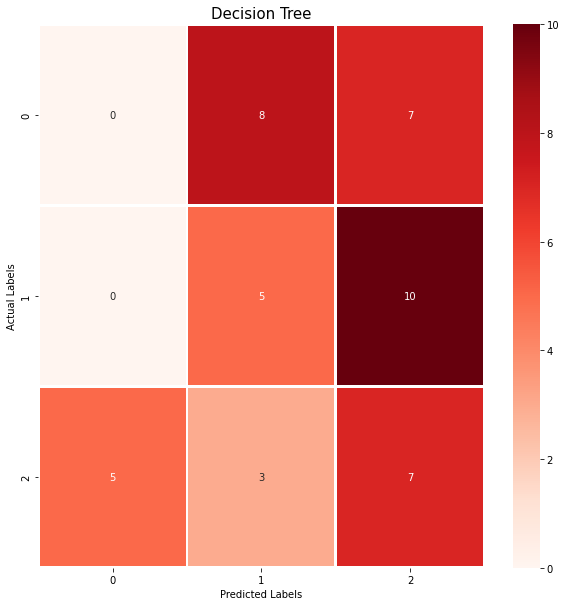



              precision    recall  f1-score   support

       enojo       0.00      0.00      0.00        15
       feliz       0.31      0.33      0.32        15
      triste       0.29      0.47      0.36        15

    accuracy                           0.27        45
   macro avg       0.20      0.27      0.23        45
weighted avg       0.20      0.27      0.23        45



0.26666666666666666

In [ ]:
y_pred_dt = dt.predict(x_test_v)
resultados_clasificador( x_test_v, y_test_v, dt, "Decision Tree", y_pred_dt)

KNN
------------------
El accuaracy para KNN es de 42.199999999999996%




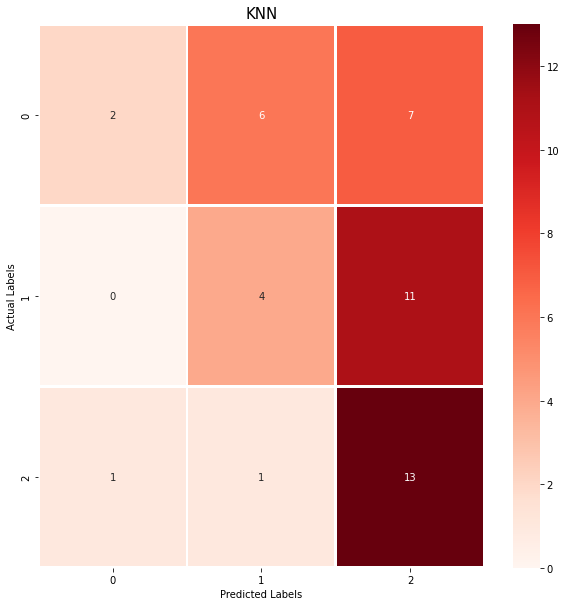



              precision    recall  f1-score   support

       enojo       0.67      0.13      0.22        15
       feliz       0.36      0.27      0.31        15
      triste       0.42      0.87      0.57        15

    accuracy                           0.42        45
   macro avg       0.48      0.42      0.37        45
weighted avg       0.48      0.42      0.37        45



0.4222222222222222

In [ ]:
y_pred_knn= knn.predict(x_test_v)
resultados_clasificador( x_test_v, y_test_v, knn, "KNN", y_pred_knn)



Random Forest
------------------
El accuaracy para Random Forest es de 51.1%




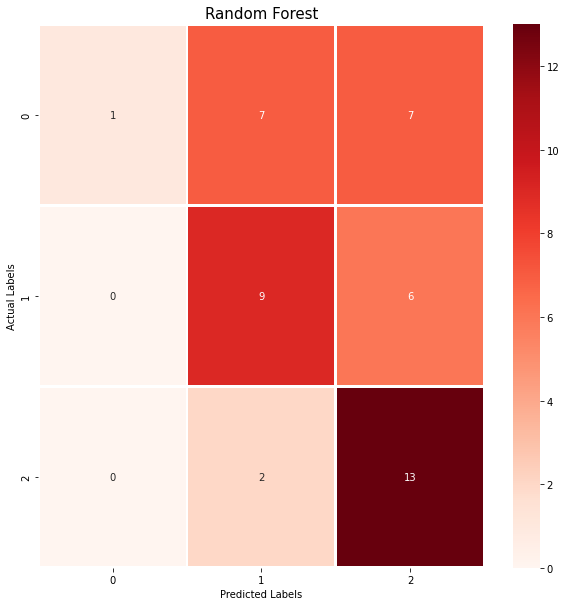



              precision    recall  f1-score   support

       enojo       1.00      0.07      0.12        15
       feliz       0.50      0.60      0.55        15
      triste       0.50      0.87      0.63        15

    accuracy                           0.51        45
   macro avg       0.67      0.51      0.43        45
weighted avg       0.67      0.51      0.43        45



0.5111111111111111

In [ ]:
y_pred_rf= rf.predict(x_test_v)
resultados_clasificador( x_test_v, y_test_v, rf, "Random Forest", y_pred_rf)